In [7]:
from pyspark.sql import SparkSession

In [8]:
spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

## Importanción de datos

In [3]:
# ! pip install papermill -q
# ! papermill --version

2.3.4 from /opt/conda/lib/python3.7/site-packages/papermill/cli.py (3.7.3)


In [9]:
months = ["2022-5","2022-4","2022-3","2022-2","2022-1","2021-12","2021-11"]
archivo_final = "datos-completos-31-5.csv"

In [5]:
! mkdir -p 'import-result'

In [6]:
# for month in months:
#     ! papermill 'importar-mes.ipynb' 'import-result/{month}.ipynb' -p mes_datos {month} -p archivo_final {archivo_final} 


Input Notebook:  importar-mes.ipynb
Output Notebook: import-result/2022-5.ipynb
Black is not installed, parameters wont be formatted
Executing: 100%|██████████████████████████████| 18/18 [04:17<00:00, 14.28s/cell]
Input Notebook:  importar-mes.ipynb
Output Notebook: import-result/2022-4.ipynb
Black is not installed, parameters wont be formatted
Executing: 100%|██████████████████████████████| 18/18 [03:11<00:00, 10.65s/cell]
Input Notebook:  importar-mes.ipynb
Output Notebook: import-result/2022-3.ipynb
Black is not installed, parameters wont be formatted
Executing: 100%|██████████████████████████████| 18/18 [03:16<00:00, 10.93s/cell]
Input Notebook:  importar-mes.ipynb
Output Notebook: import-result/2022-2.ipynb
Black is not installed, parameters wont be formatted
Executing: 100%|██████████████████████████████| 18/18 [02:41<00:00,  8.95s/cell]
Input Notebook:  importar-mes.ipynb
Output Notebook: import-result/2022-1.ipynb
Black is not installed, parameters wont be formatted
Executing: 

In [10]:
! ls

2021-11.csv  2022-2.csv  2022-5.csv	    datos-completos.csv  wget-log
2021-12.csv  2022-3.csv  ComprasChile.html  importar-mes.ipynb	 work
2022-1.csv   2022-4.csv  datasets	    import-result


In [12]:
df_original_corregido = spark.read.format("csv").options(header=True, delimiter=';',encoding="ISO-8859-1").csv(archivo_final)

In [13]:
df_original_corregido.show(10,vertical=True)

-RECORD 0------------------------------------------
 ID                         | 34790455             
 Codigo                     | 2403-1556-SE17       
 Link                       | http://www.mercad... 
 Nombre                     | TD Mejoramiento c... 
 Descripcion/Obervaciones   | DECRETO DE ADJUDI... 
 Tipo                       | SE                   
 ProcedenciaOC              | licitación públic... 
 EsTratoDirecto             | Si                   
 EsCompraAgil               | No                   
 CodigoTipo                 | 8                    
 CodigoAbreviadoTipoOC      | SE                   
 DescripcionTipoOC          | Sin emisión autom... 
 codigoEstado               | 4                    
 Estado                     | Enviada a proveedor  
 codigoEstadoProveedor      | 1                    
 EstadoProveedor            | Nueva orden de co... 
 FechaCreacion              | 2017-09-27           
 FechaEnvio                 | 2022-05-23           
 FechaSolici

## Ingeniería de Atributos

### Columnas Relevantes
Eliminamos las columnas que no sean relevanes para nuestro analisis, dejando solo las que sí podemos llegar a utilizar 

In [14]:
df_original = df_original_corregido

In [15]:
df_original.columns

['ID',
 'Codigo',
 'Link',
 'Nombre',
 'Descripcion/Obervaciones',
 'Tipo',
 'ProcedenciaOC',
 'EsTratoDirecto',
 'EsCompraAgil',
 'CodigoTipo',
 'CodigoAbreviadoTipoOC',
 'DescripcionTipoOC',
 'codigoEstado',
 'Estado',
 'codigoEstadoProveedor',
 'EstadoProveedor',
 'FechaCreacion',
 'FechaEnvio',
 'FechaSolicitudCancelacion',
 'fechaUltimaModificacion',
 'FechaAceptacion',
 'FechaCancelacion',
 'tieneItems',
 'PromedioCalificacion',
 'CantidadEvaluacion',
 'MontoTotalOC',
 'TipoMonedaOC',
 'MontoTotalOC_PesosChilenos',
 'Impuestos',
 'TipoImpuesto',
 'Descuentos',
 'Cargos',
 'TotalNetoOC',
 'CodigoUnidadCompra',
 'RutUnidadCompra',
 'UnidadCompra',
 'CodigoOrganismoPublico',
 'OrganismoPublico',
 'sector',
 'ActividadComprador',
 'CiudadUnidadCompra',
 'RegionUnidadCompra',
 'PaisUnidadCompra',
 'CodigoSucursal',
 'RutSucursal',
 'Sucursal',
 'CodigoProveedor',
 'NombreProveedor',
 'ActividadProveedor',
 'ComunaProveedor',
 'RegionProveedor',
 'PaisProveedor',
 'Financiamiento',
 'P

In [16]:
df_columnas_relevantes = df_original[
    ['Estado',
 'FechaCreacion',
 'FechaAceptacion',
 'MontoTotalOC_PesosChilenos',
 'OrganismoPublico',
 'sector',
 'CiudadUnidadCompra',
 'RegionUnidadCompra',
 'PaisProveedor',
 'IDItem',
 'RubroN1',
 'RubroN2',
 'RubroN3',
 'cantidad',
 'UnidadMedida']
]

In [17]:
df_columnas_relevantes.show(15,vertical=True)

-RECORD 0------------------------------------------
 Estado                     | Enviada a proveedor  
 FechaCreacion              | 2017-09-27           
 FechaAceptacion            | NA                   
 MontoTotalOC_PesosChilenos | 1080919609,14        
 OrganismoPublico           | I MUNICIPALIDAD D... 
 sector                     | Municipalidades      
 CiudadUnidadCompra         | Peñalolén            
 RegionUnidadCompra         | Región Metropolit... 
 PaisProveedor              | Chile                
 IDItem                     | 89939120             
 RubroN1                    | Servicios de cons... 
 RubroN2                    | Construcción de e... 
 RubroN3                    | Construcción de o... 
 cantidad                   | 1                    
 UnidadMedida               | Unidad               
-RECORD 1------------------------------------------
 Estado                     | Aceptada             
 FechaCreacion              | 2018-11-13           
 FechaAcepta

In [18]:
df_columnas_relevantes.count()

2587212

#### Eliminar filas que no cuentas con un Estado válido. Deberían ser solo 5 posibles valores

In [19]:
df_columnas_relevantes.select("Estado").distinct().show(vertical=True)

-RECORD 0----------------------
 Estado | Compra Ágil          
-RECORD 1----------------------
 Estado | Sin emisión autom... 
-RECORD 2----------------------
 Estado | Convenio Marco       
-RECORD 3----------------------
 Estado | 8                    
-RECORD 4----------------------
 Estado | Estado               
-RECORD 5----------------------
 Estado | 5                    
-RECORD 6----------------------
 Estado |  Llave               
-RECORD 7----------------------
 Estado | 6                    
-RECORD 8----------------------
 Estado | Costo de evaluaci... 
-RECORD 9----------------------
 Estado | CM                   
-RECORD 10---------------------
 Estado | Cancelacion solic... 
-RECORD 11---------------------
 Estado | En proceso           
-RECORD 12---------------------
 Estado | AG                   
-RECORD 13---------------------
 Estado | Adquisición igual... 
-RECORD 14---------------------
 Estado | SE                   
-RECORD 15---------------------
 Estado 

In [20]:
estados_validos = ["Aceptada", "En proceso","Cancelacion solicitada", "Enviada a proveedor", "Recepcion Conforme"] 

In [21]:
df_estados_validos =df_columnas_relevantes.filter(df_columnas_relevantes.Estado.isin(estados_validos))
df_estados_validos.select("Estado").distinct().show(vertical=True)

-RECORD 0----------------------
 Estado | Cancelacion solic... 
-RECORD 1----------------------
 Estado | En proceso           
-RECORD 2----------------------
 Estado | Recepcion Conforme   
-RECORD 3----------------------
 Estado | Enviada a proveedor  
-RECORD 4----------------------
 Estado | Aceptada             



### Analisis de atributos


In [156]:
df = df_estados_validos

In [157]:
df.printSchema()

root
 |-- Estado: string (nullable = true)
 |-- FechaCreacion: string (nullable = true)
 |-- FechaAceptacion: string (nullable = true)
 |-- MontoTotalOC_PesosChilenos: string (nullable = true)
 |-- OrganismoPublico: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- CiudadUnidadCompra: string (nullable = true)
 |-- RegionUnidadCompra: string (nullable = true)
 |-- PaisProveedor: string (nullable = true)
 |-- IDItem: string (nullable = true)
 |-- RubroN1: string (nullable = true)
 |-- RubroN2: string (nullable = true)
 |-- RubroN3: string (nullable = true)
 |-- cantidad: string (nullable = true)
 |-- UnidadMedida: string (nullable = true)



In [158]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0----------------------------
 Estado                     | 0      
 FechaCreacion              | 0      
 FechaAceptacion            | 0      
 MontoTotalOC_PesosChilenos | 0      
 OrganismoPublico           | 0      
 sector                     | 0      
 CiudadUnidadCompra         | 336    
 RegionUnidadCompra         | 0      
 PaisProveedor              | 201426 
 IDItem                     | 0      
 RubroN1                    | 0      
 RubroN2                    | 0      
 RubroN3                    | 0      
 cantidad                   | 45     
 UnidadMedida               | 11     



Convertimos las fechas a formato fecha

In [159]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, IntegerType, DateType

In [160]:
# Convert the date column to a datetype with format year-month-day
from pyspark.sql.functions import to_date
df = df.withColumn('FechaCreacion', to_date(col('FechaCreacion'), 'yyyy-MM-dd'))
df = df.withColumn('FechaAceptacion', to_date(col('FechaAceptacion'), 'yyyy-MM-dd'))

In [161]:
df['FechaCreacion','FechaAceptacion'].printSchema()

root
 |-- FechaCreacion: date (nullable = true)
 |-- FechaAceptacion: date (nullable = true)



In [162]:
from pyspark.sql.functions import regexp_replace
df = df.withColumn('MontoTotalOC_PesosChilenos', regexp_replace('MontoTotalOC_PesosChilenos', ',', '.'))
df = df.withColumn('MontoTotalOC_PesosChilenos', df['MontoTotalOC_PesosChilenos'].cast(DoubleType()))

In [163]:
df = df.filter(df.cantidad.rlike("[0-9,]"))
df = df.withColumn('cantidad', regexp_replace('cantidad', ',', '.'))
df = df.withColumn('cantidad', col('cantidad').cast(DoubleType())) 

Convertimos los valores númericos a sus repectivos tipos

In [164]:
df = df.withColumn('IDItem', col('IDItem').cast(IntegerType()))

In [165]:
df['MontoTotalOC_PesosChilenos','IDItem', 'cantidad'].printSchema()

root
 |-- MontoTotalOC_PesosChilenos: double (nullable = true)
 |-- IDItem: integer (nullable = true)
 |-- cantidad: double (nullable = true)



In [166]:
# count how many rows have null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0----------------------------
 Estado                     | 0      
 FechaCreacion              | 0      
 FechaAceptacion            | 153161 
 MontoTotalOC_PesosChilenos | 0      
 OrganismoPublico           | 0      
 sector                     | 0      
 CiudadUnidadCompra         | 336    
 RegionUnidadCompra         | 0      
 PaisProveedor              | 201375 
 IDItem                     | 0      
 RubroN1                    | 0      
 RubroN2                    | 0      
 RubroN3                    | 0      
 cantidad                   | 283    
 UnidadMedida               | 9      



La explicación de por qué la columna FechaAceptación tiene nulos es porque no todas las compras fueron aceptadas, mientras que todas las compras fueron creadas (sino no estarían en el dataset)

In [167]:
df.show(15,vertical=True)

-RECORD 0------------------------------------------
 Estado                     | Enviada a proveedor  
 FechaCreacion              | 2017-09-27           
 FechaAceptacion            | null                 
 MontoTotalOC_PesosChilenos | 1.08091960914E9      
 OrganismoPublico           | I MUNICIPALIDAD D... 
 sector                     | Municipalidades      
 CiudadUnidadCompra         | Peñalolén            
 RegionUnidadCompra         | Región Metropolit... 
 PaisProveedor              | Chile                
 IDItem                     | 89939120             
 RubroN1                    | Servicios de cons... 
 RubroN2                    | Construcción de e... 
 RubroN3                    | Construcción de o... 
 cantidad                   | 1.0                  
 UnidadMedida               | Unidad               
-RECORD 1------------------------------------------
 Estado                     | Aceptada             
 FechaCreacion              | 2018-11-13           
 FechaAcepta

In [168]:
df.printSchema()

root
 |-- Estado: string (nullable = true)
 |-- FechaCreacion: date (nullable = true)
 |-- FechaAceptacion: date (nullable = true)
 |-- MontoTotalOC_PesosChilenos: double (nullable = true)
 |-- OrganismoPublico: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- CiudadUnidadCompra: string (nullable = true)
 |-- RegionUnidadCompra: string (nullable = true)
 |-- PaisProveedor: string (nullable = true)
 |-- IDItem: integer (nullable = true)
 |-- RubroN1: string (nullable = true)
 |-- RubroN2: string (nullable = true)
 |-- RubroN3: string (nullable = true)
 |-- cantidad: double (nullable = true)
 |-- UnidadMedida: string (nullable = true)



In [169]:
df.count()

2583518

### Convertimos a Pandas

Primero vamos a hacer un 'sample' de nuestro datos ya que Pandas no soporta los 2 millones de datos que tenemos. Por lo tanto, los resultados del PandaReport son una representación del dataset original.

In [170]:
df_sample = df.sample(False, 0.3, seed = 1)

In [171]:
import sys
import seaborn as sns 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [172]:
dfp = df_sample.toPandas() 

In [173]:
dfp.head(10) 

,Estado,FechaCreacion,FechaAceptacion,MontoTotalOC_PesosChilenos,OrganismoPublico,sector,CiudadUnidadCompra,RegionUnidadCompra,PaisProveedor,IDItem,RubroN1,RubroN2,RubroN3,cantidad,UnidadMedida
0,Enviada a proveedor,2017-09-27,None,1.080920e+09,I MUNICIPALIDAD DE PENALOLEN,Municipalidades,Peñalolén,Región Metropolitana de Santiago,Chile,89939120,Servicios de construcción y mantenimiento,Construcción de edificios en general,Construcción de obras civiles y infraestructuras,1.0,Unidad
1,Aceptada,2018-11-13,2022-05-26,2.838800e+09,SERVICIO DE VIVIENDA Y URBANIZACION VII REGION,Obras Públicas,Talca,Región del Maule,Chile,99540856,Servicios de construcción y mantenimiento,Construcción de edificios en general,Construcción de obras civiles y infraestructuras,1.0,Global
2,Aceptada,2018-11-13,2022-05-26,2.838800e+09,SERVICIO DE VIVIENDA Y URBANIZACION VII REGION,Obras Públicas,Talca,Región del Maule,Chile,99540857,Servicios de construcción y mantenimiento,Construcción de edificios en general,Construcción de obras civiles y infraestructuras,1.0,Global
3,Enviada a proveedor,2020-01-06,None,5.950000e+00,I MUNICIPALIDAD DE CERRILLOS,Municipalidades,Cerrillos,Región Metropolitana de Santiago,Chile,108796689,"Servicios profesionales, administrativos y con...",Servicios para la comercialización y distribución,Distribución,1.0,Unidad
4,Recepcion Conforme,2020-08-27,2022-05-09,4.023592e+05,SERVICIO DE SALUD HOSPITAL DE RENGO,Salud,Rengo,Región del Libertador General Bernardo O´Higgins,Chile,112484357,Equipamiento y suministros médicos,Productos quirúrgicos,"Juegos de instrumentos, sistemas y bandejas qu...",1.0,Global
5,Recepcion Conforme,2021-01-14,2022-05-09,6.188000e+04,SERVICIO DE SALUD COQUIMBO HOSPITAL DR. HUMBER...,Salud,Illapel,Región de Coquimbo,NA,114790898,Equipamiento y suministros médicos,Equipos y suministros odontológicos,Suministros y equipos de odontología cosmética,13.0,Unidad
6,Recepcion Conforme,2021-01-29,2022-05-05,2.605779e+06,SERVICIO DE SALUD ORIENTE HOSPITAL DEL SALVADOR,Salud,Providencia,Región Metropolitana de Santiago,Chile,122021788,Medicamentos y productos farmacéuticos,Medicamentos inmunomoduladores,Inmunodepresores,10.0,Unidad
7,Aceptada,2021-04-13,2022-05-23,1.823270e+06,SERVICIO DE SALUD CHILOE,Salud,Castro,Región de los Lagos,Chile,116057842,"Ropa, maletas y productos de aseo personal",Artículos de baño o tocador,Artículos de baño y cuerpo,19152.0,Unidad
8,Aceptada,2021-06-10,2022-05-18,5.702480e+05,COMPLEJO ASISTENCIAL DR. SOTERO DEL RIO,Salud,Puente Alto,Región Metropolitana de Santiago,Chile,116943864,"Ropa, maletas y productos de aseo personal",Artículos de baño o tocador,Artículos dentales,80.0,Unidad
9,Recepcion Conforme,2021-07-01,2022-05-25,1.178100e+07,HOSPITAL PUERTO MONTT SERVICIO DE SALUD DEL RE...,Salud,Puerto Montt,Región de los Lagos,Chile,117230674,Medicamentos y productos farmacéuticos,Agentes antitumorales,Antimetabolitos,3000.0,Frasco Ampolla


In [174]:
df_category = dfp
print(df_category.columns)

Index(['Estado', 'FechaCreacion', 'FechaAceptacion',
       'MontoTotalOC_PesosChilenos', 'OrganismoPublico', 'sector',
       'CiudadUnidadCompra', 'RegionUnidadCompra', 'PaisProveedor', 'IDItem',
       'RubroN1', 'RubroN2', 'RubroN3', 'cantidad', 'UnidadMedida'],
      dtype='object')


In [175]:
for col in df_category.columns:
    df_category[col] = df_category[col].astype('category')
    df_category[col] = df_category[col].cat.codes

In [176]:
dfpandas = df_category

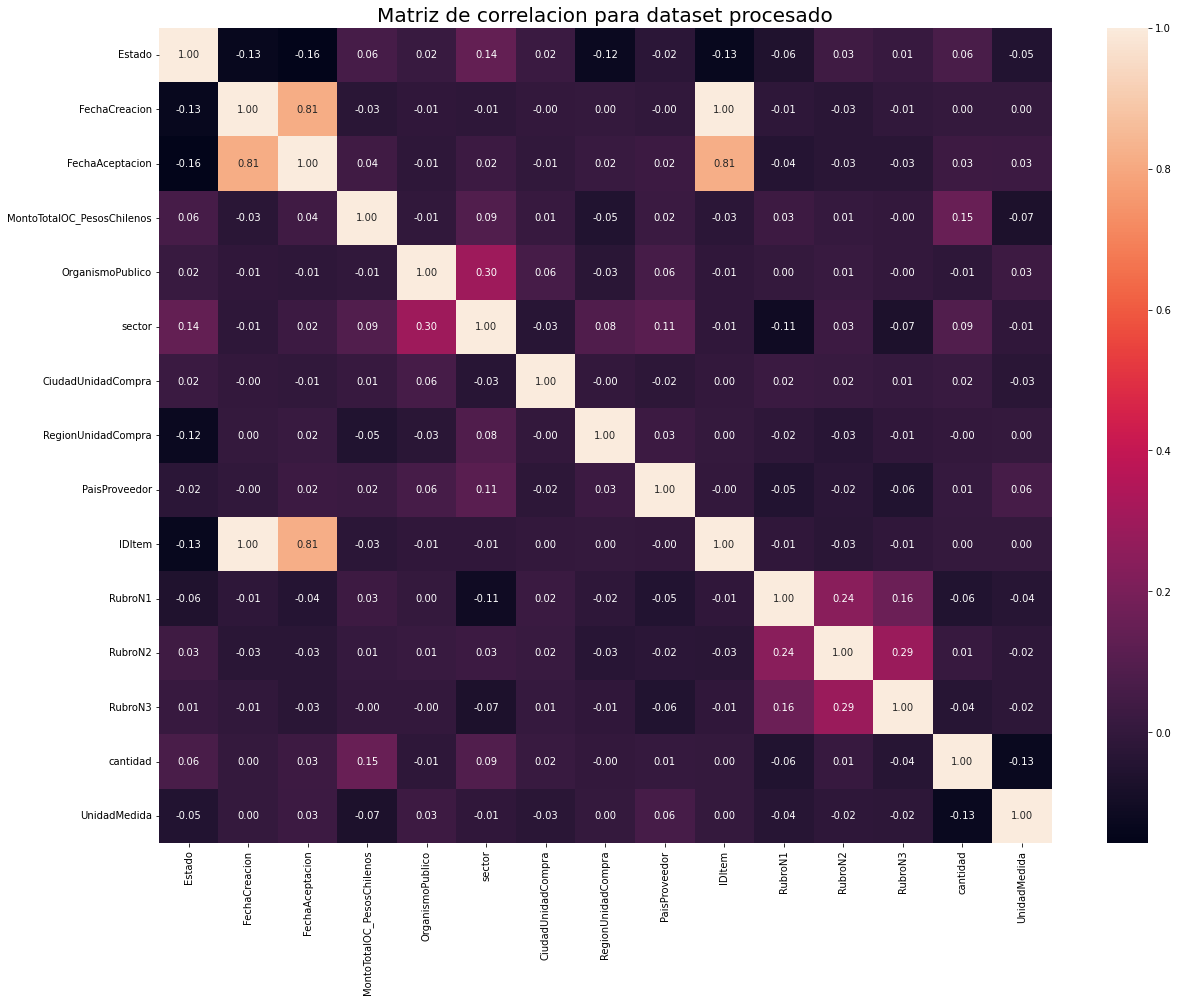

In [177]:
# Correlation matrix
corr = dfpandas.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr,  annot = True, fmt = '.2f')
plt.title('Matriz de correlacion para dataset procesado', fontsize = 20)
plt.show()

In [178]:
# ! pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

In [179]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
%matplotlib inline

profile = ProfileReport(dfpandas, title="Compras del estado Chileno", minimal = True)

In [180]:
profile.to_file("ComprasChile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Análisis de DataSets en base a preguntas objetivo

In [181]:
from pyspark.sql.functions import *

In [182]:
# # UDF to process the currancy column

conversionRate = 800 # How many chilean pesos = 1 dollar, estimated 
def toCurrancy (pesos):
    
    dollars = pesos/conversionRate
    # roundedDollars = format_number(dollars,2)
    finalDollars = f'US$ {dollars}'
    return finalDollars
    
udfToCurrancy = udf(lambda x: toCurrancy(x))

In [183]:
udfToDollars = udf(lambda x: 0 if x is None else x/800)

In [184]:
# format(123,"b")

#### ¿ Cual fue el gasto total del Estado Chileno en los meses analizados? 

Vamos a usar este valor como referencia para las consultas posteriores

In [185]:
df.select(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+----------------------+
|Total Gastos          |
+----------------------+
|US$ 19296558481.784412|
+----------------------+



#### ¿Qué áreas está el Estado chileno invirtiendo más?

In [186]:
# Primero comparamos por sector 
df.groupBy("sector").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+---------------------------+----------------------+
|sector                     |Total Gastos          |
+---------------------------+----------------------+
|Salud                      |US$ 9140982952.07336  |
|Municipalidades            |US$ 4163129208.921431 |
|Gob. Central, Universidades|US$ 3940400673.407895 |
|FFAA                       |US$ 1381389997.2443807|
|Obras Públicas             |US$ 424422809.1417977 |
|Otros                      |US$ 139768648.41560945|
|Legislativo y judicial     |US$ 106463692.39467688|
|NA                         |US$ 500.185           |
+---------------------------+----------------------+



In [187]:

df_sector = df.groupBy("sector").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToDollars(col('Total Gastos')))

df_sector = df_sector.withColumn('Total Gastos', df_sector['Total Gastos'].cast(DoubleType()))
df_sector.printSchema()

root
 |-- sector: string (nullable = true)
 |-- Total Gastos: double (nullable = true)



In [188]:
distinct_sectores = [x.sector for x in df_sector.select(col("sector")).distinct().collect()]
dfp_sector = df_sector.toPandas()

<BarContainer object of 8 artists>

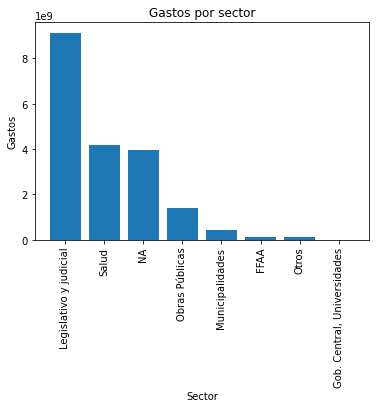

In [189]:
plt.title("Gastos por sector")
plt.xlabel("Sector")
plt.ylabel("Gastos")
plt.xticks(rotation=90, horizontalalignment="center")
plt.bar(distinct_sectores, dfp_sector["Total Gastos"])

In [190]:
# Despues por rubros
df.groupBy("RubroN1").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+-------------------------------------------------------------------------------------------------------+----------------------+
|RubroN1                                                                                                |Total Gastos          |
+-------------------------------------------------------------------------------------------------------+----------------------+
|Equipamiento y suministros médicos                                                                     |US$ 2894063870.165091 |
|Equipamiento para laboratorios                                                                         |US$ 2312798435.839395 |
|Salud, servicios sanitarios y alimentación                                                             |US$ 1692528689.597693 |
|Medicamentos y productos farmacéuticos                                                                 |US$ 1255459927.5666409|
|NA                                                                                              

In [191]:
# Organizada por Oganismo
df.groupBy("OrganismoPublico").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+-------------------------------------------------------------------+----------------------+
|OrganismoPublico                                                   |Total Gastos          |
+-------------------------------------------------------------------+----------------------+
|CENTRAL DE ABASTECIMIENTO DEL SISTEMA NACIONAL DE SERVICIO DE SALUD|US$ 1100392540.7352586|
|JUNTA NACIONAL DE AUXILIO ESCOLAR Y BECA                           |US$ 1032213429.5188076|
|FONDO NACIONAL DE SALUD                                            |US$ 917812023.9465157 |
|SUBSECRETARIA DE SALUD PUBLICA                                     |US$ 620118255.469775  |
|I MUNICIPALIDAD DE VITACURA                                        |US$ 498211593.9527102 |
|DIRECCION DE ABASTECIMIENTO DE LA ARMADA                           |US$ 305132131.07362705|
|DIRECCION DE LOGISTICA DE CARABINEROS                              |US$ 295654003.07375044|
|HOSPITAL GUILLERMO GRANT BENAVENTE DE CO                           |U

#### ¿Cuántos gastos mayores al millón de dólares fueron efectuados entre el  noviembre 2021 y mayo de 2022?

In [192]:
df_gastos = df.select(col("MontoTotalOC_PesosChilenos")).filter(udfToDollars(col("MontoTotalOC_PesosChilenos")) > 1000000.00).orderBy(desc("MontoTotalOC_PesosChilenos")).withColumn('MontoTotalOC_PesosChilenos', udfToCurrancy(col('MontoTotalOC_PesosChilenos')))
df_gastos.show(truncate=False)

+--------------------------+
|MontoTotalOC_PesosChilenos|
+--------------------------+
|US$ 180793733.7822        |
|US$ 160531139.8845        |
|US$ 137111022.9523125     |
|US$ 124999999.99795       |
|US$ 101605205.7897625     |
|US$ 90002897.79019737     |
|US$ 85728076.0788375      |
|US$ 83474885.3616125      |
|US$ 82047239.01125        |
|US$ 77958575.1287875      |
|US$ 69490000.20891249     |
|US$ 68750000.0            |
|US$ 58892400.512695245    |
|US$ 55239733.7289         |
|US$ 54584927.2032875      |
|US$ 53655761.25           |
|US$ 48889654.77689999     |
|US$ 40448885.32375        |
|US$ 30769383.75           |
|US$ 29278462.5            |
+--------------------------+
only showing top 20 rows



In [193]:
df_gastos.count()

1125

#### ¿Cuál fue el gasto promedio en general?

In [194]:
df.select(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio de Gastos")).withColumn('Promedio de Gastos', udfToCurrancy(col('Promedio de Gastos'))).show(truncate=False)

+---------------------+
|Promedio de Gastos   |
+---------------------+
|US$ 7469.101621039379|
+---------------------+



#### ¿Cuál fue el gasto promedio por mes?

In [195]:
df.filter(~col("FechaAceptacion").isNull()).groupBy(month(col("FechaAceptacion")).alias("Mes")).agg(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio Gastos")).orderBy(desc("Promedio Gastos")).withColumn('Promedio Gastos', udfToCurrancy(col('Promedio Gastos'))).show(truncate=False)

+---+----------------------+
|Mes|Promedio Gastos       |
+---+----------------------+
|4  |US$ 8886.924194756082 |
|1  |US$ 7733.39857138297  |
|2  |US$ 7520.633271631128 |
|12 |US$ 7509.860858906118 |
|3  |US$ 7500.9920141175135|
|5  |US$ 6805.256133604525 |
|11 |US$ 5912.731330693129 |
+---+----------------------+



In [196]:
df_promedio_mes = df.filter(~col("FechaAceptacion").isNull()).groupBy(month(col("FechaAceptacion")).alias("Mes")).agg(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio Gastos")).orderBy(desc("Promedio Gastos")).withColumn('Promedio Gastos', udfToDollars(col('Promedio Gastos')))

df_promedio_mes = df_promedio_mes.withColumn('Promedio Gastos', df_promedio_mes['Promedio Gastos'].cast(DoubleType()))
df_promedio_mes.printSchema()

root
 |-- Mes: integer (nullable = true)
 |-- Promedio Gastos: double (nullable = true)



In [197]:
dfp_promedio_mes = df_promedio_mes.toPandas()

<BarContainer object of 7 artists>

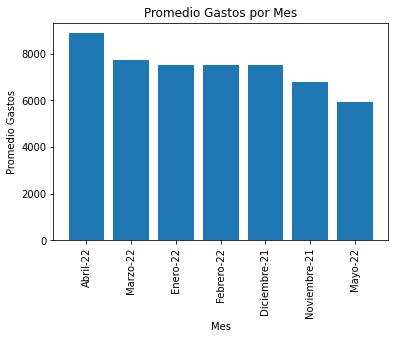

In [200]:
x = ['Abril-22', 'Marzo-22', 'Enero-22', 'Febrero-22', 'Diciembre-21', 'Noviembre-21', 'Mayo-22']
plt.title("Promedio Gastos por Mes")
plt.xlabel("Mes")
plt.ylabel("Promedio Gastos")
plt.xticks(rotation=90, horizontalalignment="center")
plt.bar(x, dfp_promedio_mes["Promedio Gastos"])

#### ¿Cuál fue la compra más repetido del estado?

In [201]:
df.select(col("IDItem")).groupBy(col("IDItem")).count().orderBy(desc("count")).show(truncate=False)

+---------+-----+
|IDItem   |count|
+---------+-----+
|119302809|3    |
|119221096|2    |
|122194044|2    |
|121667811|2    |
|121361741|2    |
|121369080|2    |
|120160195|2    |
|122239748|2    |
|121922883|2    |
|119221094|2    |
|121435741|2    |
|121408768|2    |
|122022272|2    |
|121391900|2    |
|121391882|2    |
|121369076|2    |
|121391893|2    |
|121459477|2    |
|122194043|2    |
|121124510|2    |
+---------+-----+
only showing top 20 rows



#### ¿En que regiónes se realizáron los mayores gastos?

In [202]:
df.groupBy("RegionUnidadCompra").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+------------------------------------------------+----------------------+
|RegionUnidadCompra                              |Total Gastos          |
+------------------------------------------------+----------------------+
|Región Metropolitana de Santiago                |US$ 9726191215.729637 |
|Región del Biobío                               |US$ 1669574831.8253264|
|Región de Valparaíso                            |US$ 1479406405.440116 |
|Región de los Lagos                             |US$ 943703690.8789825 |
|Región de la Araucanía                          |US$ 836759325.3841362 |
|Región del Maule                                |US$ 747147902.9702007 |
|Región del Libertador General Bernardo O´Higgins|US$ 557784473.5291831 |
|Región de Coquimbo                              |US$ 485359333.11864173|
|Región de Antofagasta                           |US$ 471098818.01557386|
|Región de Tarapacá                              |US$ 452090128.9755069 |
|Región del Ñuble                     

In [203]:
df_region = df.groupBy("RegionUnidadCompra").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToDollars(col('Total Gastos')))

df_region = df_region.withColumn('Total Gastos', df_region['Total Gastos'].cast(DoubleType()))
df_region.printSchema()

root
 |-- RegionUnidadCompra: string (nullable = true)
 |-- Total Gastos: double (nullable = true)



In [204]:
distinct_regions = [x.RegionUnidadCompra for x in df_region.select(col("RegionUnidadCompra")).distinct().collect()]
dfp_region = df_region.toPandas()

<BarContainer object of 17 artists>

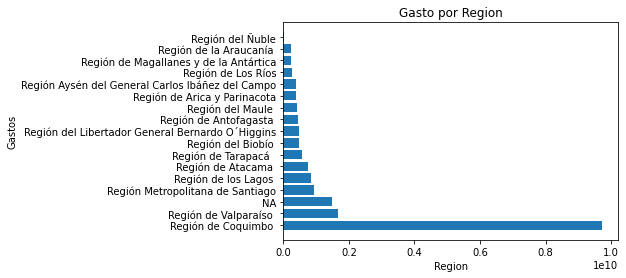

In [205]:
plt.title("Gasto por Region")
plt.xlabel("Region")
plt.ylabel("Gastos")
plt.xticks(rotation=0, horizontalalignment="center")
plt.barh(distinct_regions, dfp_region["Total Gastos"])

In [206]:
# ¿En que ciudades se realizáron los mayores gastos?
df.groupBy("CiudadUnidadCompra").agg(sum(col("MontoTotalOC_PesosChilenos")).alias("Total Gastos")).orderBy(desc("Total Gastos")).withColumn('Total Gastos', udfToCurrancy(col('Total Gastos'))).show(truncate=False)

+------------------+----------------------+
|CiudadUnidadCompra|Total Gastos          |
+------------------+----------------------+
|Santiago          |US$ 4050483734.5224714|
|Ñuñoa             |US$ 1279047861.940128 |
|Valparaíso        |US$ 631125192.8908137 |
|Concepción        |US$ 522534088.8630412 |
|Providencia       |US$ 508981904.49704146|
|Vitacura          |US$ 499591950.92922   |
|Puerto Montt      |US$ 492305832.1736099 |
|San Miguel        |US$ 349411891.39090437|
|Temuco            |US$ 348539520.2187585 |
|Independencia     |US$ 346407874.7875627 |
|Talca             |US$ 346060463.46316916|
|Puente Alto       |US$ 326906370.5329699 |
|Antofagasta       |US$ 318792386.13193226|
|Iquique           |US$ 313520892.82657343|
|Talcahuano        |US$ 296247267.33693826|
|Viña del Mar      |US$ 293719460.10062975|
|Los Angeles       |US$ 284642727.70607   |
|Alhué             |US$ 262051981.01589024|
|La Florida        |US$ 221856301.2597122 |
|Arica             |US$ 21240165

In [207]:
# ¿Cuál es el tiempo promedio desde que se solicita la orden de compra, hasta que se autorice?
df.select(avg(datediff(col("FechaAceptacion"), col("FechaCreacion"))).alias("Promedio de Tiempo")).orderBy(desc("Promedio de Tiempo")).show(truncate=False)


+------------------+
|Promedio de Tiempo|
+------------------+
|7.205086330938212 |
+------------------+

